In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 

from unlearning import probes, leace, plotting
reload(probes)
reload(plotting)
reload(leace)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



def check_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")
    print(f"Max Memory Cached: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")  


BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)



Using device: cuda


okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

Files already downloaded and verified
Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


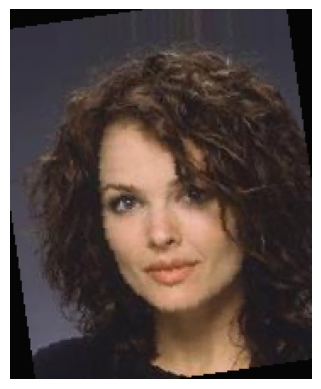

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets
from unlearning import model_utils
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

NUM_WORKERS = 4
train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



from unlearning import plotting
reload(plotting)

image_ = val_dataset[0][0]
plotting.show_image(image_)


## Load model

In [3]:
print(f"load model:")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


model = model_utils.load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 4)



vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]



model_layer_count = probes.get_layer_count(model)
print(f"layer count - {model_layer_count}")

# print model accuracy
accuracy = (all_preds == all_labels).float().mean()

#

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


load model:
Using device: cuda


/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_without_attr.load_state_dict(torch.load(

evaluate model:


 20%|██        | 4/20 [00:32<02:08,  8.05s/it]

layer count - 10


In [4]:

check_memory()
print(f"model accuracy - {accuracy}")
attribute_index = 20


print(f"vals[{attribute_index} ] = {vals[attribute_index]}")
reload(plotting)
print(f"accuracy - {plotting.compute_precision_recall_acc(vals[attribute_index])}")
# get probe accuracy 
#train_labels = train_dataset.attr
val_labels = val_dataset.attr
# attribute names 
attr_names = val_dataset.attr_names
print(f"attribute of interest - {attr_names[attribute_index]}")

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0


N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)


# set up a probe dataset 
print(f"len pos_indices - {len(pos_indices)}")
print(f"len neg_indices - {len(neg_indices)}")
# shuffle neg_indices



Memory Allocated: 122.224609375 MB
Max Memory Allocated: 8624.115234375 MB
Memory Cached: 10912.0 MB
Max Memory Cached: 10912.0 MB
model accuracy - 0.913769543170929
vals[20 ] = (tensor(1754), tensor(2286), tensor(17), tensor(39))
accuracy - (tensor(99.0401), tensor(97.8249), tensor(98.6328))
attribute of interest - Male
len pos_indices - 8458
len neg_indices - 11409


/tmp/ipykernel_1271029/435768503.py:26: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1271029/435768503.py:27: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


In [5]:
#print probe layer accs
reload(probes)
plot_probes = False
if plot_probes:
    probes.plot_probes(pos_indices, neg_indices, model, val_dataset, device)


# Identify contrastive examples (for probe-ability) 

Observation, evaluation here should be lower than the general probe-ability.

construct probing-dataset from the constrastive examples

see `finding_contrastive_examples.ipynb` for more indepth treatment of this

In [ ]:
from unlearning import contrastive_examples
from collections import defaultdict
reload(contrastive_examples)


N = 1000


layer_ind = 8

reload(contrastive_examples)

### Pulling out the - create probe-dataset function.
closest_probe_dataset, closest_probe_dataset_labels = contrastive_examples.create_probe_dataset_contrastive_examples(dataset= val_dataset, labels= val_labels, model = model, layer_ind = layer_ind, attribute_index=attribute_index, N =N, N_to_search=N*4)



negative_attributes = val_labels[:, attribute_index] == 0
val_pos_indices = torch.where(val_labels[:, attribute_index] == 1)[0]
val_neg_indices = torch.where(negative_attributes)[0]

val_neg_indices_subset = np.random.choice(val_neg_indices, size=N, replace=False)

normal_probe_dataset, normal_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=val_pos_indices, neg_indices=val_neg_indices_subset, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)

/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/contrastive_examples.py:211: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/contrastive_examples.py:212: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


probe_labels 19867 ; <class 'torch.Tensor'>
model_layer_count- 10
init
model_device: cuda:0
model embeddinging size 2048
embedding 0/4000; embedding_counts 1
embedding 400/4000; embedding_counts 401
embedding 800/4000; embedding_counts 801
embedding 1200/4000; embedding_counts 1201
embedding 1600/4000; embedding_counts 1601
embedding 2000/4000; embedding_counts 2001
embedding 2400/4000; embedding_counts 2401
embedding 2800/4000; embedding_counts 2801
embedding 3200/4000; embedding_counts 3201
embedding 3600/4000; embedding_counts 3601
built search engine
embedding 0/1000
embedding 100/1000
embedding 200/1000
embedding 300/1000
embedding 400/1000
embedding 500/1000
embedding 600/1000
embedding 700/1000
embedding 800/1000
embedding 900/1000
ordered_nearest_distances- len793
len(closest_neg_indices) - 793
closest_neg_indices -793
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scr

(array([187.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 200.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

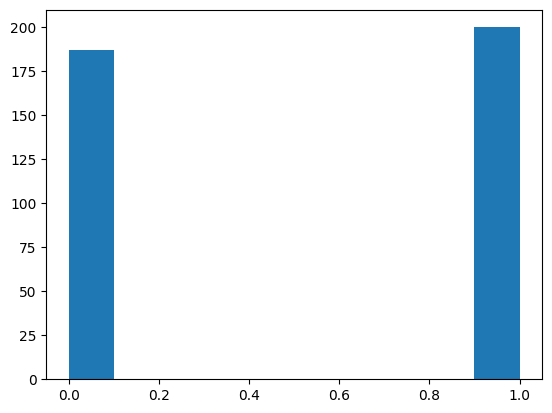

In [8]:
plt.hist(closest_probe_dataset_labels)

In [9]:
# test probe
reload(probes)


print(f"Probe on random vals")

linear_probe_random = probes.test_linear_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)
MLP_probe_random = probes.test_MLP_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_random_acc - {linear_probe_random[0]}")
print(f"\tMLP_probe_random_acc - {MLP_probe_random[0]}")


print(f"Probe on closest vals")
linear_probe_closest = probes.test_linear_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

MLP_probe_closest = probes.test_MLP_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_closest_acc - {linear_probe_closest[0]}")
print(f"\tMLP_probe_closest_acc - {MLP_probe_closest[0]}")


Probe on random vals
	linear_probe_random_acc - 99.7112512588501
	MLP_probe_random_acc - 100.0
Probe on closest vals
	linear_probe_closest_acc - 99.74160194396973
	MLP_probe_closest_acc - 100.0


## If we minimize probe accuracy on train set, how does that effect the probe accuracy on the val set?

In [10]:
for i, attr_name in enumerate(train_dataset.attr_names):
    print(f"attribute {i} - {attr_name}")


model_attribute_ind = 0
probe_attribute_index = 13


print(f"attribute = {train_dataset.attr_names[attribute_index]}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)

layer_count = probes.get_layer_count(model)
layer_ind = layer_count - 2


attribute 0 - 5_o_Clock_Shadow
attribute 1 - Arched_Eyebrows
attribute 2 - Attractive
attribute 3 - Bags_Under_Eyes
attribute 4 - Bald
attribute 5 - Bangs
attribute 6 - Big_Lips
attribute 7 - Big_Nose
attribute 8 - Black_Hair
attribute 9 - Blond_Hair
attribute 10 - Blurry
attribute 11 - Brown_Hair
attribute 12 - Bushy_Eyebrows
attribute 13 - Chubby
attribute 14 - Double_Chin
attribute 15 - Eyeglasses
attribute 16 - Goatee
attribute 17 - Gray_Hair
attribute 18 - Heavy_Makeup
attribute 19 - High_Cheekbones
attribute 20 - Male
attribute 21 - Mouth_Slightly_Open
attribute 22 - Mustache
attribute 23 - Narrow_Eyes
attribute 24 - No_Beard
attribute 25 - Oval_Face
attribute 26 - Pale_Skin
attribute 27 - Pointy_Nose
attribute 28 - Receding_Hairline
attribute 29 - Rosy_Cheeks
attribute 30 - Sideburns
attribute 31 - Smiling
attribute 32 - Straight_Hair
attribute 33 - Wavy_Hair
attribute 34 - Wearing_Earrings
attribute 35 - Wearing_Hat
attribute 36 - Wearing_Lipstick
attribute 37 - Wearing_Necklac

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

evaluate model:


 20%|██        | 4/20 [00:29<01:59,  7.44s/it]


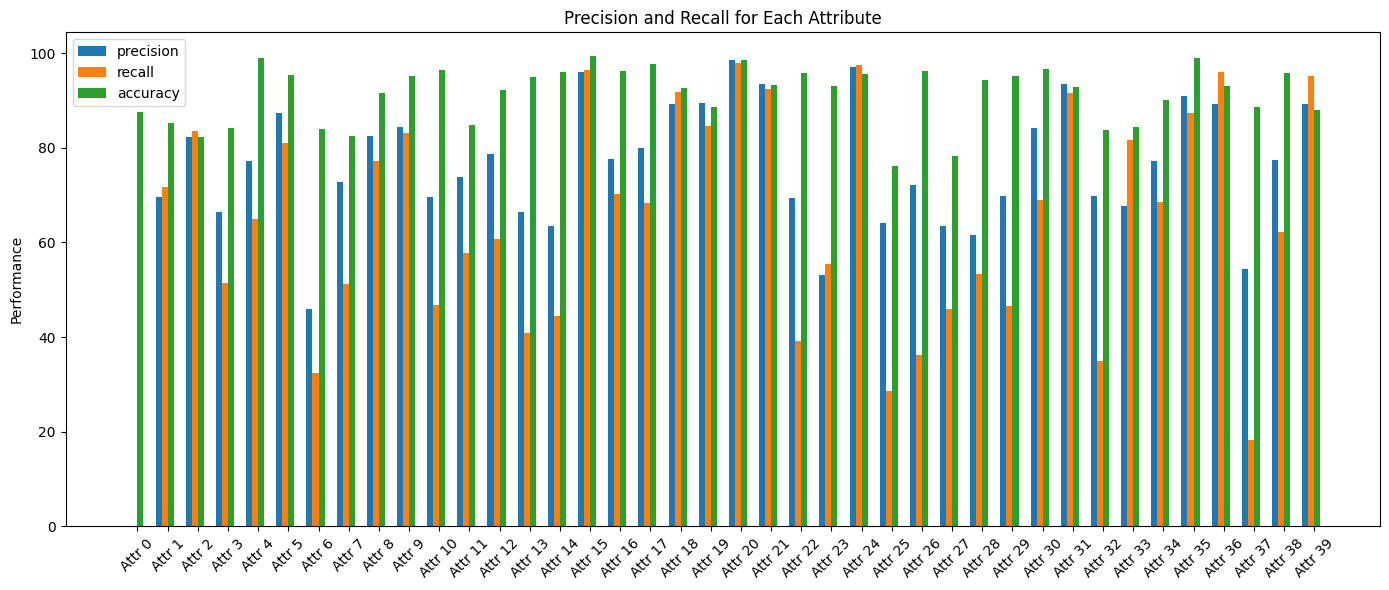

In [11]:
# evaluate model
print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 4)
# plot bars
vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]
vals = np.array(vals)

reload(plotting)
plotting.generate_precision_recall_chart(vals)

In [ ]:
# okay let's run GA on the closest_neg_indices, from the train set
reload(probes)
# TODO: replace this block with just 
# closest_probe_dataset, closest_probe_dataset_labels = contrastive_examples.create_probe_dataset_contrastive_examples(dataset= val_dataset, labels= val_labels, model = model, layer_ind = layer_ind, attribute_index=attribute_index, N =N, N_to_search=N*4)


train_dataset
train_labels = train_dataset.attr
#print(f"train_dataset - {train_dataset}")
print(f"train_labels - {train_labels.shape}")

# 1. construct probe dataset for train_dataset 
# 2. make a quick function for compute "closest_counterfactuals "

print(f"attribute of interest - {attr_names[attribute_index]}")


positive_attributes = train_labels[:, probe_attribute_index] == 1
negative_attributes = train_labels[:, probe_attribute_index] == 0
pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]


N = min(2000, len(pos_indices), len(neg_indices))


val_positive_attributes = val_labels[:, probe_attribute_index] == 1
val_negative_attributes = val_labels[:, probe_attribute_index] == 0
val_pos_indices = torch.where(val_positive_attributes)[0]
val_neg_indices = torch.where(val_negative_attributes)[0]

val_N = min(1000, len(val_pos_indices), len(val_neg_indices))
# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)

# shuffle pos_indices
np.random.shuffle(val_pos_indices)
np.random.shuffle(val_neg_indices)

print(f"pos indices - {len(pos_indices)}")
print(f"neg indices - {len(neg_indices)}")

embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)
print(f"layer: { layer_ind} ; embedding size: {embedding_size}")

print(f"compute train probe set:")

probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=neg_indices[:N], dataset = train_dataset, device = device, verbose = True)

print(f"compute val probe set:")
val_probe_dataset, val_probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=val_pos_indices[:val_N], neg_indices=val_neg_indices[:val_N], dataset = val_dataset, device = device, verbose = True)




train_labels - torch.Size([162770, 40])
attribute of interest - Male


/tmp/ipykernel_1271029/2049898676.py:31: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1271029/2049898676.py:32: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


pos indices - 9389
neg indices - 153381
model_device: cuda:0
layer: 8 ; embedding size: 2048
compute train probe set:
generating loader from scratch
batching embeddings


/tmp/ipykernel_1271029/2049898676.py:35: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(val_pos_indices)
/tmp/ipykernel_1271029/2049898676.py:36: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(val_neg_indices)
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get 

Processing batch 1/8
Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8
generating loader from scratch
batching embeddings
Processing batch 1/8
Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8
compute val probe set:
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [13]:
reload(probes)
for l_ in range(layer_count):
    input_dummy_shape =torch.Size([1, 3, 218, 178])
    #print(input_dummy_shape)

    embedding_size = probes.get_embedding_size(model, l_, input_dummy_shape=input_dummy_shape)
    print(f"layer: {l_} ; embedding size: \t\t{embedding_size}")

        
    embedding_size = probes.get_embedding_size(model, l_, )
    print(f"layer: {l_} ; default embedding size: \t{embedding_size}")


model_device: cuda:0
layer: 0 ; embedding size: 		620864
model_device: cuda:0
layer: 0 ; default embedding size: 	620864
model_device: cuda:0


layer: 1 ; embedding size: 		620864
model_device: cuda:0
layer: 1 ; default embedding size: 	620864
model_device: cuda:0
layer: 2 ; embedding size: 		620864
model_device: cuda:0
layer: 2 ; default embedding size: 	620864
model_device: cuda:0
layer: 3 ; embedding size: 		158400
model_device: cuda:0
layer: 3 ; default embedding size: 	158400
model_device: cuda:0
layer: 4 ; embedding size: 		633600
model_device: cuda:0
layer: 4 ; default embedding size: 	633600
model_device: cuda:0
layer: 5 ; embedding size: 		329728
model_device: cuda:0
layer: 5 ; default embedding size: 	329728
model_device: cuda:0
layer: 6 ; embedding size: 		172032
model_device: cuda:0
layer: 6 ; default embedding size: 	172032
model_device: cuda:0
layer: 7 ; embedding size: 		86016
model_device: cuda:0
layer: 7 ; default embedding size: 	86016
model_device: cuda:0
layer: 8 ; embedding size: 		2048
model_device: cuda:0
layer: 8 ; default embedding size: 	2048
model_device: cuda:0
layer: 9 ; embedding size: 		40
model_

In [14]:
do_example_probe = False 

if do_example_probe:
    pt_count= 1000
    reload(probes)
    #for layer_ind in [0,8,9]:


    pos_subset = Subset(train_dataset, pos_indices)
    pos_loader = DataLoader(pos_subset, batch_size=256, shuffle=False, num_workers=4)
    neg_subset = Subset(train_dataset, neg_indices)
    neg_loader = DataLoader(neg_subset, batch_size=256, shuffle=False, num_workers=4)

    loaders = (pos_loader, neg_loader)
    loaders= None
    probe_accs= []
    layers_ = [0,4, 7,8,9]
    for layer_ind in layers_:
        embedding_size = probes.get_embedding_size(model, layer_ind)
        print(f"layer_ind - {layer_ind} ; embedding_size : {embedding_size}")

        probe_acc = probes.mlp_probe(model=model, layer_ind = layer_ind, pos_indices=pos_indices[:pt_count], neg_indices=neg_indices[:pt_count], dataset= train_dataset,device=DEVICE, verbose = True, num_epochs = 1000, loaders=loaders)[0]
        print(f"probe acc - {probe_acc}")
        probe_accs.append(probe_acc)
        print("----")


    # plot probe accs
    plt.plot(layers_, probe_accs)
    plt.xlabel("Layer index")
    plt.show()

In [15]:
check_memory()

Memory Allocated: 161.013671875 MB
Max Memory Allocated: 8662.904296875 MB
Memory Cached: 10934.0 MB
Max Memory Cached: 10934.0 MB


In [16]:
# train MLP on probe_dataset
mlp_probe = probes.test_MLP_probe(probe_dataset= probe_dataset, probe_labels = probe_labels, model= model, num_epochs= 1000, verbose= True)
# (probe_acc, probe_dataset, probe_labels, probe_model)
mlp_probe

linear_probe = probes.test_linear_probe(probe_dataset= probe_dataset, probe_labels = probe_labels, model= model, num_epochs= 1000, verbose= True)

Epoch [100/1000], Loss: 0.2310
Epoch [200/1000], Loss: 0.1882
Epoch [300/1000], Loss: 0.1445
Epoch [400/1000], Loss: 0.1087
Epoch [500/1000], Loss: 0.0879
Epoch [600/1000], Loss: 0.0690
Epoch [700/1000], Loss: 0.0644
Epoch [800/1000], Loss: 0.1289
Epoch [900/1000], Loss: 0.0528
Epoch [1000/1000], Loss: 0.0443
Accuracy: 99.25%
Epoch [100/1000], Loss: 0.2452
Epoch [200/1000], Loss: 0.2337
Epoch [300/1000], Loss: 0.2237
Epoch [400/1000], Loss: 0.2144
Epoch [500/1000], Loss: 0.2057
Epoch [600/1000], Loss: 0.1976
Epoch [700/1000], Loss: 0.1900
Epoch [800/1000], Loss: 0.1828
Epoch [900/1000], Loss: 0.1761
Epoch [1000/1000], Loss: 0.1696
Accuracy: 93.68%


# Iterative GA on the probes

In [17]:
# copy the model
import copy
original_model = copy.deepcopy(model)

This is on random 

In [ ]:
from torch.utils.data import Dataset
pt_count = 1000
from torch.utils.data import DataLoader
reload(probes)
from unlearning.probes import CustomLabeledDataset

pt_count = min(len(pos_indices), len(neg_indices), pt_count)
probe_indices = torch.concat((pos_indices[:pt_count], neg_indices[:pt_count]), dim=0)
probe_labels = torch.concat([torch.ones(pt_count), torch.zeros(pt_count)], dim=0)

probe_dataset = CustomLabeledDataset(
    base_dataset=train_dataset,
    indices=probe_indices,
    custom_labels=probe_labels
)

# create val probe dataset :
val_probe_indices = torch.concat((val_pos_indices[:val_N], val_neg_indices[:val_N]), dim=0)
val_probe_labels = torch.concat([torch.ones(val_N), torch.zeros(val_N)], dim=0)
val_probe_dataset = CustomLabeledDataset(
    base_dataset=val_dataset,
    indices=val_probe_indices,
    custom_labels=val_probe_labels
)


probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True, num_workers=4)

val_probe_loader = DataLoader(val_probe_dataset, batch_size=64, shuffle=True, num_workers=4)

In [29]:
print(f"size of val_probe_dataset - {len(val_probe_dataset)}")
print(f"size of probe_dataset - {len(probe_dataset)}")

size of val_probe_dataset - 2000
size of probe_dataset - 2000


In [19]:
reload(probes)
# load model 
print(f"model_attribute_ind - {model_attribute_ind}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


model_attribute_ind - 0


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

In [ ]:

# 
reload(probes)
layer_ind = 8
### set up an MLP probe



embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)

probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
probe_model = probe_model.to(device)

probe_model = probes.train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind=layer_ind, device=device)
correct, total = probes.eval_probe(model, probe_model, val_probe_loader, device, layer_ind=layer_ind, max_steps = 6)

print(f"valuation : Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")

# print the train set acc:
correct, total = probes.eval_probe(model, probe_model, probe_loader, device, layer_ind = layer_ind, max_steps = 6)
print(f"train : Accuracy of the probe model on the train set: {100 * correct / total:.2f}%")



model_device: cuda:0


embedding 0/2000
embedding 200/2000
embedding 400/2000
embedding 600/2000
embedding 800/2000
embedding 1000/2000
embedding 1200/2000
embedding 1400/2000
embedding 1600/2000
embedding 1800/2000
Epoch [100/100], Loss: 0.5659
Accuracy: 77.55%
val step - 0/ 32
val step - 4/ 32
valuation : Accuracy of the probe model on the validation set: 81.25%
val step - 0/ 32
val step - 4/ 32
train : Accuracy of the probe model on the train set: 76.79%


## running different kinds of GA operations

In [ ]:
from unlearning import iterative_ga
reload(iterative_ga)
#GA_based_concept_optimization
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)
print(f"probe accuracy")
correct, total = probes.eval_probe(model, probe_model, probe_loader, device, layer_ind=layer_ind, max_steps =3)
print(f"total - {total}; correct - {correct}")
print(f"Accuracy of the model on the train set: {100 * correct / total:.2f}%")



# 
if False:
    model = iterative_ga.iterative_probe_GA(model, probe_model, probe_loader, device,  layer_ind=layer_ind, loss_fn_type= "mse", lr = 1e-2, epochs = 8, min_loss = .01)
else:
    model = iterative_ga.iterative_probe_GA_maximize_KL(model, probe_model, probe_loader, device,  layer_ind=layer_ind, loss_fn_type= "kl", lr = 1e-2, epochs = 7, min_loss = .1)


print(f"probe accuracy")
correct, total = probes.eval_probe(model, probe_model, probe_loader, device, layer_ind=layer_ind, max_steps =4)
print(f"total - {total}; correct - {correct}")
print(f"Accuracy of the probe on the train set: {100 * correct / total:.2f}%")

# evaluate on val
print(f"val probe accuracy")
correct, total = probes.eval_probe(model, probe_model, val_probe_loader, device, layer_ind=layer_ind, max_steps =4)
print(f"total - {total}; correct - {correct}")
print(f"Accuracy of the probe on the validation set: {100 * correct / total:.2f}%")


probe accuracy
val step - 0/ 32
val step - 4/ 32
total - 256; correct - 187
Accuracy of the model on the train set: 73.05%
unfreezing layer 7
unfreezing layer 8
Unfrozen parameters count: 14964736
Epoch [1], Step [1/32], Loss: 0.7435
0 -- Loss: 0.0533
probe accuracy
val step - 0/ 32
val step - 4/ 32
total - 320; correct - 150
Accuracy of the model on the train set: 46.88%
val probe accuracy
val step - 0/ 32
val step - 4/ 32
total - 320; correct - 155
Accuracy of the model on the validation set: 48.44%


In [22]:
## TODO - implement GD on the retain set - even ~10% of it. them check the probe and the model accuracies on the validation set.

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:32<00:59,  4.61s/it]


----


 35%|███▌      | 7/20 [00:32<00:59,  4.60s/it]

---
difference_before_and_after - 10.974469866071429


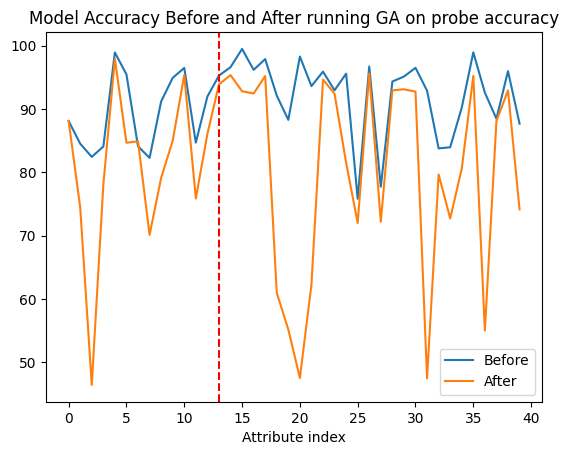

In [23]:
# test model accuracy in general
max_rounds= 7
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = max_rounds)
# plot bars
vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]
vals = np.array(vals)

print(f"----")
accs_after = [plotting.compute_precision_recall_acc(val)[2] for val in vals]

original_preds, original_labels = model_utils.evaluate(original_model, val_loader, max_rounds = max_rounds)
original_vals = [(model_utils.get_TP_TN_FP_FN(i, original_labels, original_preds)[0]) for i in range(40)]
original_vals = np.array(original_vals)



accs_before = [plotting.compute_precision_recall_acc(val)[2] for val in original_vals]
print("---")
# plot before and after
plt.plot(accs_before, label='Before')
plt.plot(accs_after, label='After')
plt.legend()
plt.xlabel("Attribute index")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("Model Accuracy Before and After running GA on probe accuracy")

# l2 norm before and after:
difference_before_and_after = sum(abs(np.array(accs_before) - np.array(accs_after))) / 40.
print(f"difference_before_and_after - {difference_before_and_after}")


{'5_o_Clock_Shadow': np.int64(18177), 'Arched_Eyebrows': np.int64(43278), 'Attractive': np.int64(83603), 'Bags_Under_Eyes': np.int64(33280), 'Bald': np.int64(3713), 'Bangs': np.int64(24685), 'Big_Lips': np.int64(39213), 'Big_Nose': np.int64(38341), 'Black_Hair': np.int64(38906), 'Blond_Hair': np.int64(24267), 'Blurry': np.int64(8362), 'Brown_Hair': np.int64(33192), 'Bushy_Eyebrows': np.int64(23386), 'Chubby': np.int64(9389), 'Double_Chin': np.int64(7571), 'Eyeglasses': np.int64(10521), 'Goatee': np.int64(10337), 'Gray_Hair': np.int64(6896), 'Heavy_Makeup': np.int64(62555), 'High_Cheekbones': np.int64(73645), 'Male': np.int64(68261), 'Mouth_Slightly_Open': np.int64(78486), 'Mustache': np.int64(6642), 'Narrow_Eyes': np.int64(18869), 'No_Beard': np.int64(135779), 'Oval_Face': np.int64(46101), 'Pale_Skin': np.int64(7005), 'Pointy_Nose': np.int64(44846), 'Receding_Hairline': np.int64(13040), 'Rosy_Cheeks': np.int64(10525), 'Sideburns': np.int64(9156), 'Smiling': np.int64(78080), 'Straight_H

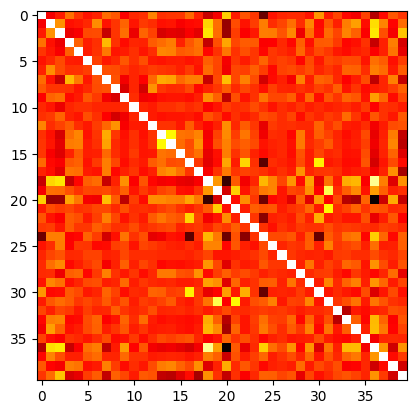

counts sorted - [np.int64(3713), np.int64(6642), np.int64(6896), np.int64(7005), np.int64(7571), np.int64(8039), np.int64(8362), np.int64(9156), np.int64(9389), np.int64(10337), np.int64(10521), np.int64(10525), np.int64(11890), np.int64(13040), np.int64(18177), np.int64(18869), np.int64(19764), np.int64(23386), np.int64(24267), np.int64(24685), np.int64(30362), np.int64(33192), np.int64(33280), np.int64(33947), np.int64(38341), np.int64(38906), np.int64(39213), np.int64(43278), np.int64(44846), np.int64(46101), np.int64(51982), np.int64(62555), np.int64(68261), np.int64(73645), np.int64(76437), np.int64(78080), np.int64(78486), np.int64(83603), np.int64(126788), np.int64(135779)]


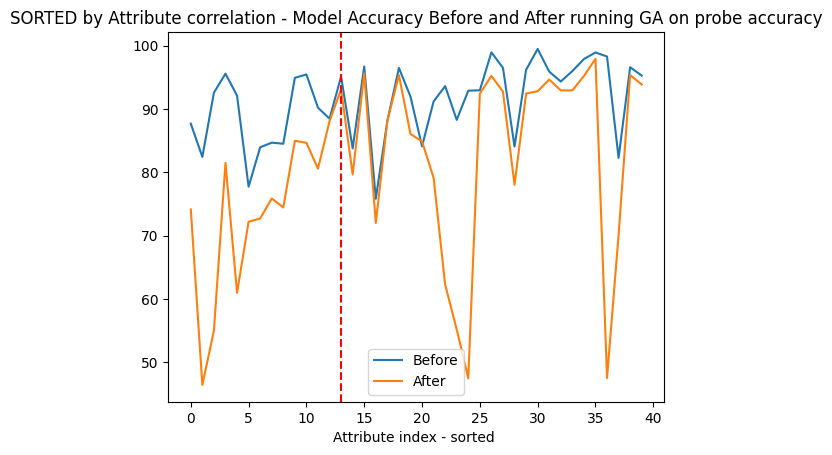

Text(0.5, 1.0, 'SORTED by # of elements - Model Accuracy Before and After running GA on probe accuracy')

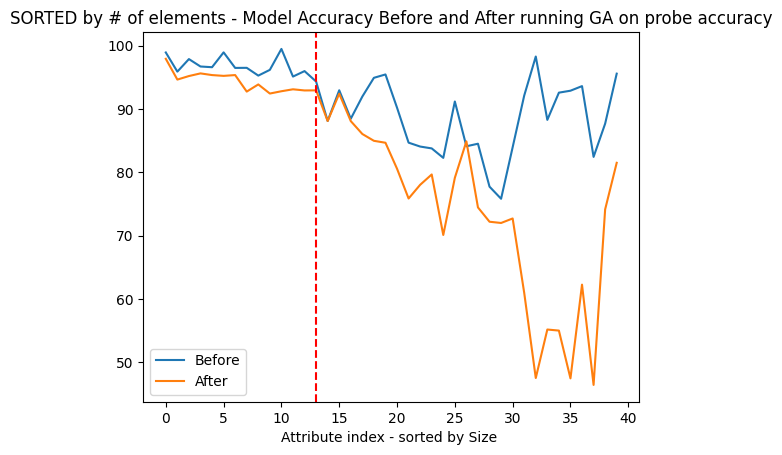

In [24]:
# can we sort the indices by correlation with the attribute of interest?
train_labels = train_dataset.attr
subset_targets = train_labels

subset_targets_np = subset_targets.numpy()


counts = np.sum(subset_targets.numpy(), axis=0)
attribute_to_count = {train_dataset.attr_names[i] : counts[i] for i in range(len(counts))}
# Sort attributes by count
#sorted_attributes = [attribute_names[i] for i in sort_attribute_indices]
#sorted_attributes = sorted

print(attribute_to_count)
correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)

# show correlation_matrix
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.show()
correlation_with_attr = correlation_matrix[:, probe_attribute_index]
arg_sort_correlation  = np.argsort(correlation_with_attr)
arg_sort_count = np.argsort(counts)
print(f"counts sorted - {[counts[i] for i in arg_sort_count]}")
accs__correlation_sorted_before = [accs_before[i] for i in arg_sort_correlation]
accs__correlation_sorted_after = [accs_after[i] for i in arg_sort_correlation]
plt.plot(accs__correlation_sorted_before, label='Before')
plt.plot(accs__correlation_sorted_after, label='After')

plt.legend()
plt.xlabel("Attribute index - sorted ")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("SORTED by Attribute correlation - Model Accuracy Before and After running GA on probe accuracy")
plt.show()


accs__size_sorted_before = [accs_before[i] for i in arg_sort_count]
accs__size_sorted_after = [accs_after[i] for i in arg_sort_count]
plt.plot(accs__size_sorted_before, label='Before')
plt.plot(accs__size_sorted_after, label='After')

plt.legend()
plt.xlabel("Attribute index - sorted by Size ")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("SORTED by # of elements - Model Accuracy Before and After running GA on probe accuracy")

### Testing an idea: GA only in the direction of GD on a different loss
1. compute GD on normal loss function, compute a subspace (PCA), for a specific layer
2. 



In [25]:
# run GD on probe dataset with regular labels

from unlearning import iterative_ga
reload(iterative_ga)

attribute_index
# get dataloader that has no attribute from attribute_index

retain_mask = train_labels[:, attribute_index] == 0
retain_indices = torch.where(retain_mask)[0]
retain_subset = Subset(train_dataset, retain_indices)
retain_loader = DataLoader(retain_subset, batch_size=256, shuffle=False, num_workers=4)
# run GD on this retain_loader
model.train()

embeddings = []



In [26]:

###
# we will compute the embeddings, then run SVD of rank ~500,;
# What we need is that the GA gradients are POSITIVELY aligned with the GD steps.
# If these are not aligned, then we haven't done anything with this projection.
# TODO - to test: what is the rank of these embeddings! (check that it is small!) 
####



In [ ]:
reload(probes)
# load model 

def project_down(data, proj_matrix):
    # (n2 x d)
    return torch.matmul(data, proj_matrix)

def project_back(data, proj_matrix):
    return torch.matmul(data, proj_matrix.T)

def positive_projections(gradient, proj_matrix):
    # x is your vector to project (shape should match columns of U)
    projections = project_down(gradient, proj_matrix)
    
    # Set negative components to 0 clearly
    projections = torch.clamp(projections, min=0) # clamp it while it's in projected space, as this confirms alignment with the projection matrix
    
    lifted = project_back(projections, proj_matrix)
    return lifted
if False:
    k = 500
    _, _ , V = compute_positive_subspace(model, retain_loader, layer_ind)
    proj_matrix = V[:,:k]






## Running projected Gradient Ascent on positive subspaces
Can we project GA-steps onto GD steps for a different loss function - plot val-probe accuracy

In [ ]:


def get_layer(model, layer_ind):
    """
    Returns the layer at the specified index from the model
    """
    for layer_i, layer_ in enumerate(model.named_children()):
        if layer_i == layer_ind:
            return layer_[1]

    
def flatten_layer_gradients(model, layer_ind):
    layer = get_layer(model, layer_ind)
    grads = []
    for param in layer.parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())
    if len(grads) == 0:
        return None
    return torch.cat(grads)

def unflatten_gradients(flat_grad, layer):
    """
    Given a flat gradient tensor and a layer, partition the flat tensor
    into a list of gradients that match the shapes of the layer's parameters.
    
    Parameters:
      flat_grad (torch.Tensor): 1D tensor of gradients.
      layer (torch.nn.Module): The layer whose parameters we're restoring gradients for.
      
    Returns:
      list: A list of tensors with shapes corresponding to the parameters of the layer.
    """
    grads = []
    offset = 0
    for p in layer.parameters():
        numel = p.numel()  # Number of elements in this parameter
        # Extract a slice from the flat tensor and reshape it to the parameter's shape
        p_grad = flat_grad[offset:offset + numel].view(p.shape)
        grads.append(p_grad)
        
        p.grad = p_grad  # Assign the gradient to the parameter
        
        offset += numel
    return grads
    

In [ ]:
check_memory()

Memory Allocated: 407.5234375 MB
Max Memory Allocated: 8910.3515625 MB
Memory Cached: 10986.0 MB
Max Memory Cached: 10986.0 MB


retain_ind - 0/23628
flattened_gradients shape - torch.Size([151, 14964736])
Memory usage: 5985894400 bytes (5845600.00 KB, 5708.59 MB)


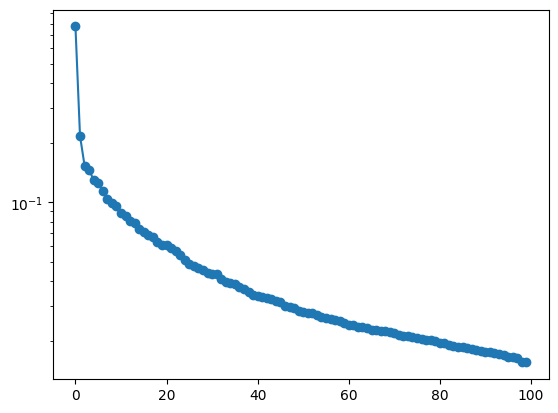

In [ ]:
criterion = nn.BCEWithLogitsLoss()

def get_flattened_gradients(model, optimizer, data_loader, layer_index, steps_to_take =100):
    all_flattened_grads = []
    report_every = len(data_loader) // 10 + 1
    for retain_ind, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.float().to(device)
        if retain_ind % report_every == 0:
            print(f"retain_ind - {retain_ind}/{len(data_loader)}")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Forward pass through model to get embeddings        
        loss.backward()
        embeddings = flatten_layer_gradients(model, layer_index)
        if embeddings is not None:
            all_flattened_grads.append(embeddings)
        if False: #  don't take every step
            optimizer.step()
        # minimize loss 
        if steps_to_take and (retain_ind >= steps_to_take) :
            break 
    all_flattened_grads = torch.stack(all_flattened_grads)
    return all_flattened_grads

def compute_float_matrix_memory_usage(n, d):
    bytes_per_float = 4  # Each float (32-bit) occupies 4 bytes.
    total_bytes = n * d * bytes_per_float
    total_kb = total_bytes / 1024
    total_mb = total_bytes / (1024 * 1024)
    print(f"Memory usage: {total_bytes} bytes ({total_kb:.2f} KB, {total_mb:.2f} MB)")
    return total_bytes

def compute_positive_subspace(model, optimizer, data_loader, layer_index, k = 100, steps_to_take= 100):
    
    flattened_gradients = get_flattened_gradients(model,optimizer, data_loader, layer_index, steps_to_take=steps_to_take)
    flattened_gradients = flattened_gradients.to(device)
    print(f"flattened_gradients shape - {flattened_gradients.shape}")
    U, S, V = torch.svd_lowrank(flattened_gradients, q=k)

    return U, S, V

model.train()
# small batch-size
retain_loader_small_batch = DataLoader(retain_subset, batch_size=4, shuffle=False, num_workers=4)

# confirm steps to take is not too big
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
# SGD 
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)


U, S, V = compute_positive_subspace(model, optimizer, retain_loader_small_batch, layer_index = 7, k = 100, steps_to_take= 150)
    # ERROR -  this errors out for memory reasons.


compute_float_matrix_memory_usage(*V.shape)

# plot S
plt.plot(S.cpu().numpy()[:10])
# plot scatter
plt.scatter(range(len(S)), S.cpu().numpy())
plt.yscale('log')
plt.show()

retain_ind - 0/23628
flattened_gradients shape - torch.Size([151, 14964736])
Memory usage: 2992947200 bytes (2922800.00 KB, 2854.30 MB)


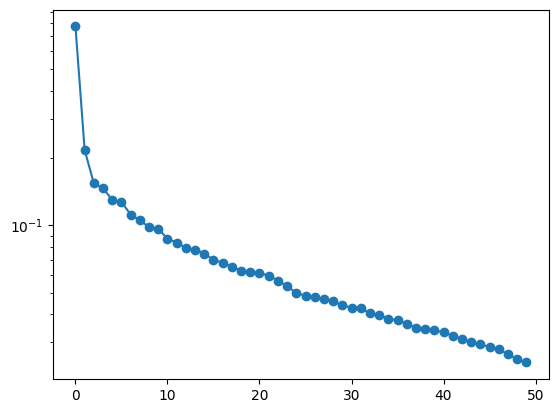

In [ ]:
_, S, V = compute_positive_subspace(model, optimizer, retain_loader_small_batch, layer_index = 7, k = 50, steps_to_take= 150)


compute_float_matrix_memory_usage(*V.shape)

# plot S
plt.plot(S.cpu().numpy()[:50])
# plot scatter
plt.scatter(range(len(S)), S.cpu().numpy())
plt.yscale('log')
plt.show()

tensor([[-2.3188e-05,  2.7186e-06,  6.5330e-05,  ..., -1.0617e-04,
          7.4915e-05,  3.0372e-04],
        [-1.9682e-06, -1.1808e-05, -2.9812e-05,  ..., -6.7891e-05,
          2.0164e-05, -2.9641e-05],
        [-1.5490e-05,  9.3990e-06,  1.9808e-05,  ..., -1.1020e-04,
         -2.5086e-05,  7.3253e-05],
        ...,
        [-2.2850e-02, -1.8109e-03,  3.0988e-03,  ...,  3.1905e-03,
         -1.4720e-03, -1.5899e-03],
        [-6.8741e-03,  8.0148e-03, -1.0764e-03,  ..., -1.4038e-02,
         -1.1865e-02,  8.0236e-03],
        [ 7.4819e-03, -5.8880e-03,  5.1354e-03,  ...,  8.7491e-03,
          4.1707e-03, -1.4347e-03]], device='cuda:0')

## positive subspace projections

/tmp/ipykernel_1211202/4288730285.py:36: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  U, _ = torch.qr(U)  # QR decomposition to get an orthonormal basis


Projected Gradient: tensor([[ 0.0000,  0.2303, -0.7589, -0.1863,  1.3789],
        [ 0.0000,  0.4617,  0.6760,  0.5349,  1.5481]])
U.shape - torch.Size([2, 2])


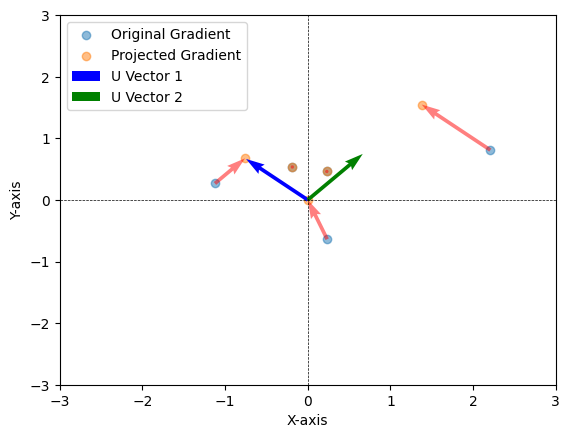

In [ ]:
V.shape

import torch

def positive_projection_onto_subspace(gradient, subspace):
    """
    Projects the gradient g onto the positive directions of the subspace spanned by U.
    
    Parameters:
      g : torch.Tensor
          The gradient vector or matrix of shape [d] or [d, b].
      U : torch.Tensor
          The subspace basis of shape [d, k]. Assumed to be orthonormal.
          
    Returns:
      g_projected : torch.Tensor
          The projected gradient with negative contributions zeroed out.
    """
    # Compute the coordinates of g in the subspace.
    coeff = subspace.t() @ gradient  # Shape: [k] or [k, b]
    
    # Zero out the negative coefficients (keeping only positive directions).
    coeff_positive = torch.clamp(coeff, min=0)
    
    # Reconstruct the projected gradient in the original space.
    g_projected = subspace @ coeff_positive
    
    return g_projected

# Example usage:
d, k, b = 2, 1, 5  # dimensions, subspace basis size, batch size
g = torch.randn(d, b)  # random gradient matrix [d x b]
U = torch.randn(d, 2)  # random subspace basis (assume it's orthonormal for this example)

# Optionally, you might want to orthonormalize U:
U, _ = torch.qr(U)  # QR decomposition to get an orthonormal basis

g_proj = positive_projection_onto_subspace(g, U)
print("Projected Gradient:", g_proj)

# plot original points, and projected points as lines
plt.scatter(g[0,:].cpu().numpy(), g[1,:].cpu().numpy(), label='Original Gradient', alpha=0.5)
plt.scatter(g_proj[0,:].cpu().numpy(), g_proj[1,:].cpu().numpy(), label='Projected Gradient', alpha=0.5)
plt.quiver(g[0,:].cpu().numpy(), g[1,:].cpu().numpy(), g_proj[0,:].cpu().numpy()-g[0,:].cpu().numpy(), g_proj[1,:].cpu().numpy()-g[1,:].cpu().numpy(), angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)

### Plot the two U vectors
plt.quiver(0, 0, U[0,0].cpu().numpy(), U[1,0].cpu().numpy(), angles='xy', scale_units='xy', scale=1, color='b', label='U Vector 1')
print(f"U.shape - {U.shape}")
plt.quiver(0, 0, U[0,1].cpu().numpy(), U[1,1].cpu().numpy(), angles='xy', scale_units='xy', scale=1, color='g', label='U Vector 2')


plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.show()



In [ ]:
#
torch.cuda.empty_cache()
import gc
gc.collect()
check_memory()

#del(U)
#del(V)

Memory Allocated: 3261.61767578125 MB
Max Memory Allocated: 26153.529296875 MB
Memory Cached: 13772.0 MB
Max Memory Cached: 36736.0 MB


### next section is WIP : compute GD subspace, and then project the GA gradients

In [ ]:
# get unfrozen param count
def get_unfrozen_param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
get_unfrozen_param_count(model)


14964736

In [ ]:
import torch

### Extract GA gradients

gradient_vectors = []
model.train()        # We need gradients from the model.
probe_model.eval()   # The probe is frozen.


layer_ind = 8
gradient_vectors = []
model.train()        # Ensure gradients are computed for the model.
probe_model.eval()   # The probe remains frozen.

# Find the target layer using the provided layer index.

compute_positive_subspace_every = 10
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


# train model, freeze probe
for param in model.parameters():
    param.requires_grad = True

for param in probe_model.parameters():
    param.requires_grad = False

freeze_layers= [layer_ind-1, layer_ind]
iterative_ga.freeze_all_but_layer_by_index(model, freeze_layers)

# count unfrozen params
unfrozen_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Unfrozen parameters count: {unfrozen_params}")

model.train()
probe_model.eval()  # Probe is frozen (eval mode recommended)
do_pos_projection = True
verbose = False 
for probe_ind, (images, labels) in enumerate(probe_loader):
    print(f"GA loader steps {probe_ind } /{len(probe_loader)}")
    images = images.to(device)
    labels = labels.to(device)
    
    # compute positve subspace 
    if do_pos_projection and (probe_ind % compute_positive_subspace_every == 0):
        print(f"comute positive subspace {probe_ind}/{len(probe_loader)}")
        _, S, V = compute_positive_subspace(model, optimizer, retain_loader_small_batch, layer_index = 7, k = 50, steps_to_take= 150)
        
    # Backward pass: updates model only, probe is frozen
    for ii, (image, label) in enumerate(zip(images, labels)):
        
        optimizer.zero_grad()

        #model.zero_grad()
        
        # Forward pass through model to get embeddings
        # unsqueeze to add batch dimension
        image = image.unsqueeze(0).to(device)
        label = label.unsqueeze(0).to(device)
        embeddings = iterative_ga.get_flattened_embedding__model(model, image, layer_ind=layer_ind)

        # Forward pass through probe (frozen)
        predictions = probe_model(embeddings)

        # Compute loss
        loss = criterion(predictions.flatten(), label)
        ascent_loss = -1 * loss
        
        ascent_loss.backward() # compute gradient
        # every 10 steps print the loss
        if ii % 10 == 0:
            print(f"GA step {ii}/{len(images)}")
            print(f"ascent_loss - {ascent_loss.item()}")
            
        # Extract gradients from the target layer.
        grads = flatten_layer_gradients(model, layer_ind-1) # hack - cause 7 and 8 are differnet
        if grads is not None:
            grad_vector = grads.detach().cpu().numpy()
            gradient_vectors.append(grad_vector)
 

        # TODO - project these gradients onto the positive subspace
        # grads = positive_projection_onto_subspace(grads, V)
        l2_norm = torch.norm(grads)
        # positive projectino
        if do_pos_projection:
            grads = positive_projection_onto_subspace(grads, V)
            if verbose:
                print(f"positive projection done")
                # compare the l2 norms:
                print(f"l2 norm before projection - {l2_norm} ;  after projection - {torch.norm(grads)}")
        # put the gradients back
        unflatten_gradients(grads, get_layer(model, layer_ind-1))
        #print(f"grads shape - {grads.shape}")
        # update the model
        optimizer.step()


        

        
    
    # print the loss
    print(f"loss - {ascent_loss.item()}")
    #break 



unfreezing layer 7
unfreezing layer 8
Unfrozen parameters count: 14964736
GA loader steps 0 /32
comute positive subspace 0/32
retain_ind - 0/23628
flattened_gradients shape - torch.Size([151, 14964736])
GA step 0/64
ascent_loss - -0.5075035691261292
GA step 10/64
ascent_loss - -0.5028793811798096
GA step 20/64
ascent_loss - -0.5065968036651611
GA step 30/64
ascent_loss - -0.5081073641777039
GA step 40/64
ascent_loss - -0.9258973002433777
GA step 50/64
ascent_loss - -0.5119460821151733
GA step 60/64
ascent_loss - -0.9069463014602661
loss - -0.9178570508956909
GA loader steps 1 /32
GA step 0/64
ascent_loss - -0.9069442749023438
GA step 10/64
ascent_loss - -0.5132969617843628
GA step 20/64
ascent_loss - -0.5187941789627075
GA step 30/64
ascent_loss - -0.9090312719345093
GA step 40/64
ascent_loss - -0.9010425806045532
GA step 50/64
ascent_loss - -0.9005096554756165
GA step 60/64
ascent_loss - -0.5230494141578674
loss - -0.5203041434288025
GA loader steps 2 /32
GA step 0/64
ascent_loss - -0

retain_ind - 0/23628
flattened_gradients shape - torch.Size([151, 14964736])
GA step 0/64
ascent_loss - -0.8234884142875671
GA step 10/64
ascent_loss - -0.8147615194320679
GA step 20/64
ascent_loss - -0.5858402252197266
GA step 30/64
ascent_loss - -0.5837459564208984
GA step 40/64
ascent_loss - -0.5805731415748596
GA step 50/64
ascent_loss - -0.58562833070755
GA step 60/64
ascent_loss - -0.8169588446617126
loss - -0.5925069451332092
GA loader steps 11 /32
GA step 0/64
ascent_loss - -0.5873137712478638
GA step 10/64
ascent_loss - -0.8155618906021118
GA step 20/64
ascent_loss - -0.5857282876968384
GA step 30/64
ascent_loss - -0.8094837665557861
GA step 40/64
ascent_loss - -0.8066236972808838
GA step 50/64
ascent_loss - -0.8049191236495972
GA step 60/64
ascent_loss - -0.5875549912452698
loss - -0.8098964095115662
GA loader steps 12 /32
GA step 0/64
ascent_loss - -0.5882518887519836
GA step 10/64
ascent_loss - -0.5925937294960022
GA step 20/64
ascent_loss - -0.5956768989562988
GA step 30/6

In [ ]:

# eval probe again
print(f"eval probe")
correct, total = probes.eval_probe(model, probe_model, val_probe_loader, device,layer_ind = layer_ind,  max_steps = 6)
print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")

eval probe
val step - 0/ 32
val step - 4/ 32
Accuracy of the probe model on the validation set: 52.46%


 35%|███▌      | 7/20 [00:37<01:09,  5.33s/it]


----


 35%|███▌      | 7/20 [00:37<01:10,  5.42s/it]

---


Text(0.5, 1.0, 'Model Accuracy Before and After running GA on probe accuracy')

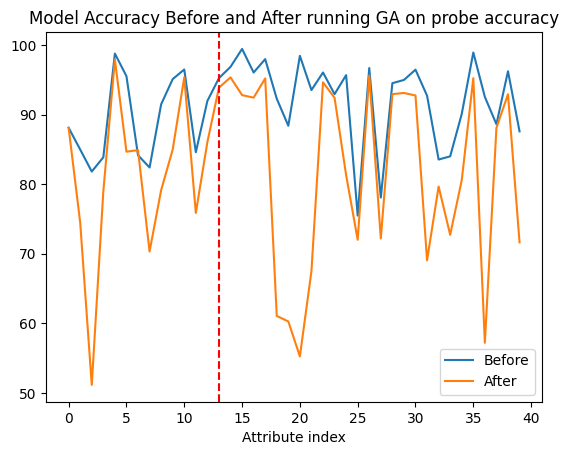

In [ ]:
# test model accuracy in general
max_rounds= 7
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = max_rounds)
# plot bars
vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]
vals = np.array(vals)

print(f"----")
accs_after = [plotting.compute_precision_recall_acc(val)[2] for val in vals]

original_preds, original_labels = model_utils.evaluate(original_model, val_loader, max_rounds = max_rounds)
original_vals = [(model_utils.get_TP_TN_FP_FN(i, original_labels, original_preds)[0]) for i in range(40)]
original_vals = np.array(original_vals)



accs_before = [plotting.compute_precision_recall_acc(val)[2] for val in original_vals]
print("---")
# plot before and after
plt.plot(accs_before, label='Before')
plt.plot(accs_after, label='After')
plt.legend()
plt.xlabel("Attribute index")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("Model Accuracy Before and After running GA on probe accuracy")


In [ ]:

# l2 norm before and after:
difference_before_and_after = sum(abs(np.array(accs_before) - np.array(accs_after))) / 40.
print(f"difference_before_and_after - {difference_before_and_after}")



difference_before_and_after - 9.86363002232143


Text(0.5, 1.0, 'SORTED by # of elements - Model Accuracy Before and After running GA on probe accuracy')

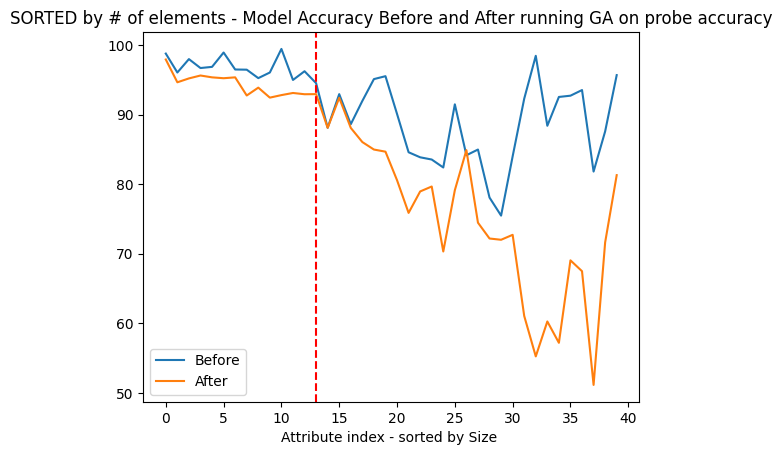

In [ ]:

counts = np.sum(subset_targets.numpy(), axis=0)
attribute_to_count = {train_dataset.attr_names[i] : counts[i] for i in range(len(counts))}

accs__size_sorted_before = [accs_before[i] for i in arg_sort_count]
accs__size_sorted_after = [accs_after[i] for i in arg_sort_count]
plt.plot(accs__size_sorted_before, label='Before')
plt.plot(accs__size_sorted_after, label='After')

plt.legend()
plt.xlabel("Attribute index - sorted by Size ")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("SORTED by # of elements - Model Accuracy Before and After running GA on probe accuracy")

## Basic Probing code

In [ ]:
# basic probing code:


reload(probes)
# load model 
print(f"model_attribute_ind - {model_attribute_ind}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
probe_model = probe_model.to(device)

print(f"train probe")
probe_model = probes.train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind, device)
print(f"eval probe")
correct, total = probes.eval_probe(model, probe_model, val_probe_loader, device, layer_ind = layer_ind, max_steps = 6)

######
# run GA on the probe model with the retain_loader
######

print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")
print(f"run GA probe")
model = iterative_ga.iterative_probe_GA(model, probe_model, probe_loader, device, layer_ind, lr = 5e-2, epochs = 10, max_loss = 1.5)

# eval probe again
print(f"eval probe")
correct, total = probes.eval_probe(model, probe_model, val_probe_loader, device,layer_ind = layer_ind,  max_steps = 6)
print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")

model_attribute_ind - 0
train probe
embedding 0/2000
embedding 200/2000
embedding 400/2000
embedding 600/2000
embedding 800/2000
embedding 1000/2000
embedding 1200/2000
embedding 1400/2000
embedding 1600/2000
embedding 1800/2000
Epoch [100/100], Loss: 0.6874
Accuracy: 76.80%
eval probe
val step - 0/ 32
val step - 4/ 32
Accuracy of the probe model on the validation set: 77.68%
run GA probe
unfreezing layer 7
unfreezing layer 8
Unfrozen parameters count: 14964736
Epoch [1], Step [1/32], Loss: 0.2352
Epoch [1], Step [8/32], Loss: 0.2371
Epoch [1], Step [15/32], Loss: 0.2331
Epoch [1], Step [22/32], Loss: 0.2399
Epoch [1], Step [29/32], Loss: 0.2413
0 -- Loss: 0.2432
Epoch [2], Step [1/32], Loss: 0.2404
Epoch [2], Step [8/32], Loss: 0.2424
Epoch [2], Step [15/32], Loss: 0.2426
Epoch [2], Step [22/32], Loss: 0.2432
Epoch [2], Step [29/32], Loss: 0.2461
1 -- Loss: 0.2508
Epoch [3], Step [1/32], Loss: 0.2494
Epoch [3], Step [8/32], Loss: 0.2458
Epoch [3], Step [15/32], Loss: 0.2525
Epoch [3],

In [ ]:
print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")


probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
probe_model = probe_model.to(device)

print(f"train probe")
probe_model = probes.train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind, device)

Accuracy of the probe model on the validation set: 21.65%
train probe
embedding 0/2000
embedding 200/2000
embedding 400/2000
embedding 600/2000
embedding 800/2000
embedding 1000/2000
embedding 1200/2000
embedding 1400/2000
embedding 1600/2000
embedding 1800/2000
Epoch [100/100], Loss: 0.6934
Accuracy: 50.00%


# Model Healing with Gradient Descent on Retain

# Scrap

In [ ]:
layer_ = get_layer(model, layer_ind-1)

for p in layer_.parameters():
    print(f"{p.grad.shape} - {p.grad.flatten().shape}")



torch.Size([512, 1024, 1, 1]) - torch.Size([524288])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([512, 512, 3, 3]) - torch.Size([2359296])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([2048, 512, 1, 1]) - torch.Size([1048576])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048, 1024, 1, 1]) - torch.Size([2097152])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048]) - torch.Size([2048])
torch.Size([512, 2048, 1, 1]) - torch.Size([1048576])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([512, 512, 3, 3]) - torch.Size([2359296])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([2048, 512, 1, 1]) - torch.Size([1048576])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048]) - torch.Size([2048])
torch.Size([512, 2048, 1, 1]) - torch.Size([1048576])
torch.Size([512]) - torch.